In [15]:
include("DenseNTK.jl")
include("FastNTK.jl")

eig_fix(K) = abs.(eigen(K).values)+ones(length(eigen(K).values))*1e-26;

Nθ(model) = sum(length, Flux.params(model)); # Calculate notal amount of params

In [2]:
Nx=300
a=-1.0; b=1.0

xVec=collect(range(a,stop=b,length=Nx));
yVec=sin.(2*pi*xVec) .+ 0.1*randn(size(xVec)); 

In [3]:
Nh = 1000
act = relu

model = Chain(DenseNTK(1,Nh,act),DenseNTK(Nh,1))

Chain(
  DenseNTK(Float32[1.3438498; 0.5763277; … ; 0.21640517; 0.46623516;;], Float32[-0.6272588, -0.07421541, -0.3796103, 1.6629984, 0.5537194, -0.42725947, 2.1025767, 0.90208787, -0.45131418, -0.90631  …  -0.03595431, -1.0616391, 0.13812351, 0.15273997, 0.05956383, -0.2613026, 0.43924266, 0.0232226, -0.4238315, -0.97572154], NNlib.relu),  # 2_000 parameters
  DenseNTK(Float32[-0.11339471 -0.36188817 … 2.510884 -0.615468], Float32[1.5618095], identity),  # 1_001 parameters
)                   # Total: 4 arrays, 3_001 parameters, 12.020 KiB.

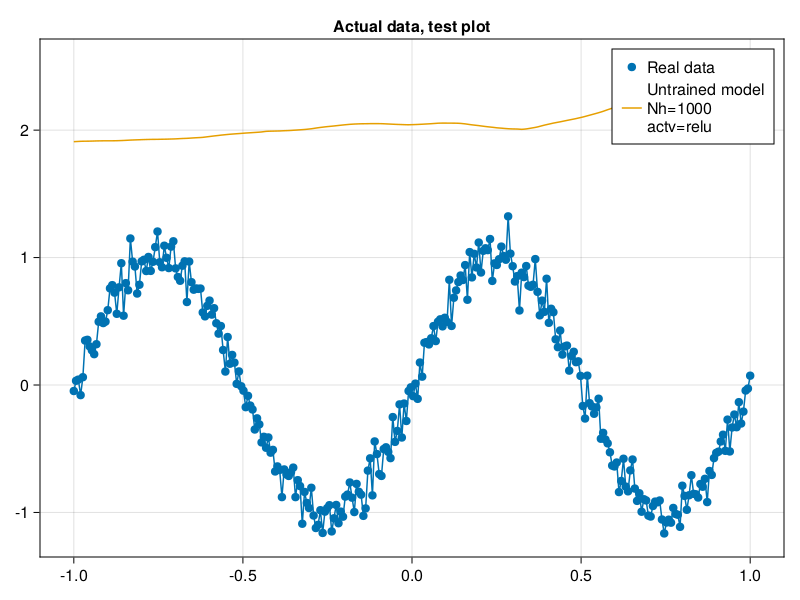

In [4]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1],title="Actual data, test plot")

CairoMakie.lines!(xVec[:], yVec[:])
CairoMakie.scatter!(xVec[:], yVec[:], label="Real data")

CairoMakie.lines!(xVec[:], model(hcat(xVec...))[:], label="Untrained model\nNh=$Nh\nactv=$act")

axislegend(ax1,position=:rt)
fig

<h1>Trektin</h1>

In [18]:
using Distributions

a = -1.0;
b = 1.0;
Nx = 100
IN = 10

# Generate random matrix with numbers from a to b (inclusive)
xTrekt = rand(Uniform(-1,1),IN,Nx)

10×100 Matrix{Float64}:
  0.213358  -0.495891     0.343792   …  -0.0586325  -0.780473   0.169131
 -0.180261   0.482586     0.622563       0.378678    0.718273  -0.0101909
 -0.112743  -0.623294    -0.805899       0.619017    0.233576  -0.919557
 -0.164309   0.913986    -0.102059      -0.355999    0.216478  -0.337083
 -0.855691  -0.00635037  -0.262827       0.417661    0.765079   0.0021124
 -0.348572  -0.459794     0.273101   …  -0.551464   -0.28239   -0.0543519
  0.738325   0.448039    -0.734106       0.592204   -0.608914   0.0472508
  0.630413   0.615637    -0.108831       0.184669   -0.490703  -0.890396
  0.310153   0.336764     0.0742839     -0.293455    0.345757   0.408657
 -0.516646  -0.579016    -0.11829       -0.0220819   0.56512    0.910077

In [19]:
OUT = 3
ACT = relu

trekt1 = Chain(DenseNTK(IN, IN-Int(round((IN-OUT)/2)), ACT), DenseNTK(IN-Int(round((IN-OUT)/2)), OUT))

trekt3 = Chain(DenseNTK(IN, 8, ACT), DenseNTK(8,7, ACT), DenseNTK(7,5,ACT), DenseNTK(5,OUT));

trektÖll = Chain(DenseNTK(IN, IN-1, ACT))

for i in 0:(IN-OUT-2)
    trektÖll = Chain(trektÖll, DenseNTK(IN-1-i, IN-2-i, ACT))
end

In [21]:
K_trekt1 = kernel(trekt1, xTrekt,true);
K_trekt3 = kernel(trekt3, xTrekt,true);
K_trektÖll = kernel(trektÖll, xTrekt,true);

In [22]:
eig_trekt1 = eig_fix(K_trekt1);
eig_trekt3 = eig_fix(K_trekt3);
eig_trektÖll = eig_fix(K_trektÖll);

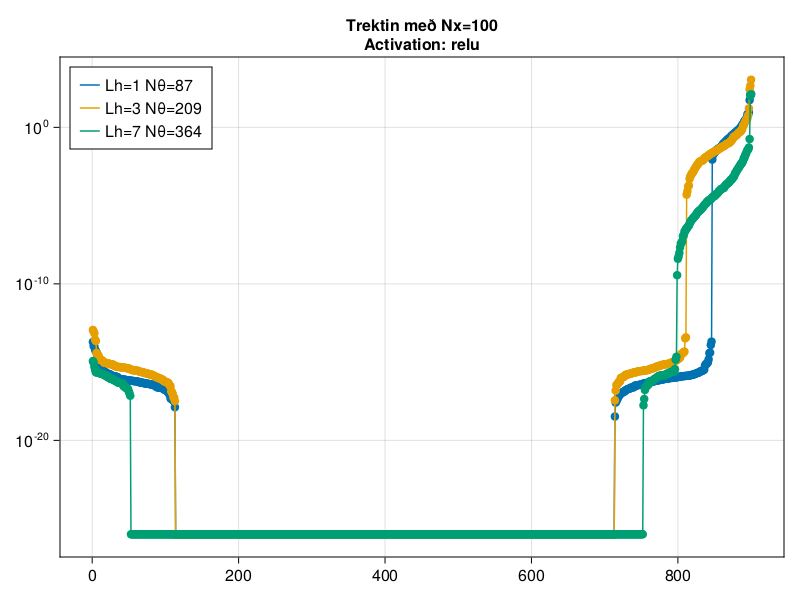

In [26]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10, title="Trektin með Nx=$Nx\nActivation: $ACT")

N1 = Nθ(trekt1)
N3 = Nθ(trekt3)
NÖll = Nθ(trektÖll)

CairoMakie.lines!(eig_trekt1, label="Lh=1 Nθ=$N1")
CairoMakie.scatter!(eig_trekt1)


CairoMakie.lines!(eig_trekt3, label="Lh=3 Nθ=$N3")
CairoMakie.scatter!(eig_trekt3)

CairoMakie.lines!(eig_trektÖll, label="Lh=$(IN-OUT) Nθ=$NÖll")
CairoMakie.scatter!(eig_trektÖll)


axislegend(ax1,position=:lt)
fig

In [49]:
t1 = []; t3 = []; töll = [];

runs = 10;

for i = 1:runs
    trekt1 = Chain(DenseNTK(IN, IN-Int(round((IN-OUT)/2)), ACT), DenseNTK(IN-Int(round((IN-OUT)/2)), OUT))
    trekt3 = Chain(DenseNTK(IN, 8, ACT), DenseNTK(8,7, ACT), DenseNTK(7,5,ACT), DenseNTK(5,OUT));
    trektÖll = Chain(DenseNTK(IN, IN-1, ACT))

    for i in 0:(IN-OUT-2)
        trektÖll = Chain(trektÖll, DenseNTK(IN-1-i, IN-2-i, ACT))
    end

    push!(t1, trekt1)
    push!(t3, trekt3)
    push!(töll, trektÖll)
end

K1 = []; K3 = []; Köll = [];

@showprogress desc="Computing kernels..." for i = 1:runs
    push!(K1, kernel(t1[i],xTrekt))
    push!(K3, kernel(t3[i],xTrekt))
    push!(Köll, kernel(töll[i],xTrekt))
end

eigval1 = []; eigval3 = []; eigvalöll = []
eigvec1 = []; eigvec3 = []; eigvecöll = []

@showprogress desc="Computing eigens...." for i = 1:runs
    E1 = eigen(K1[i]);
    E3 = eigen(K3[i]);
    Eöll = eigen(Köll[i]);

    push!(eigval1, E1.values)
    push!(eigvec1, E1.vectors)

    push!(eigval3, E3.values)
    push!(eigvec3, E3.vectors)
    
    push!(eigvalöll, Eöll.values)
    push!(eigvecöll, Eöll.vectors)

end


Computing kernels... 100%|███████████████████████████████| Time: 0:00:05
Computing eigens.... 100%|███████████████████████████████| Time: 0:00:02


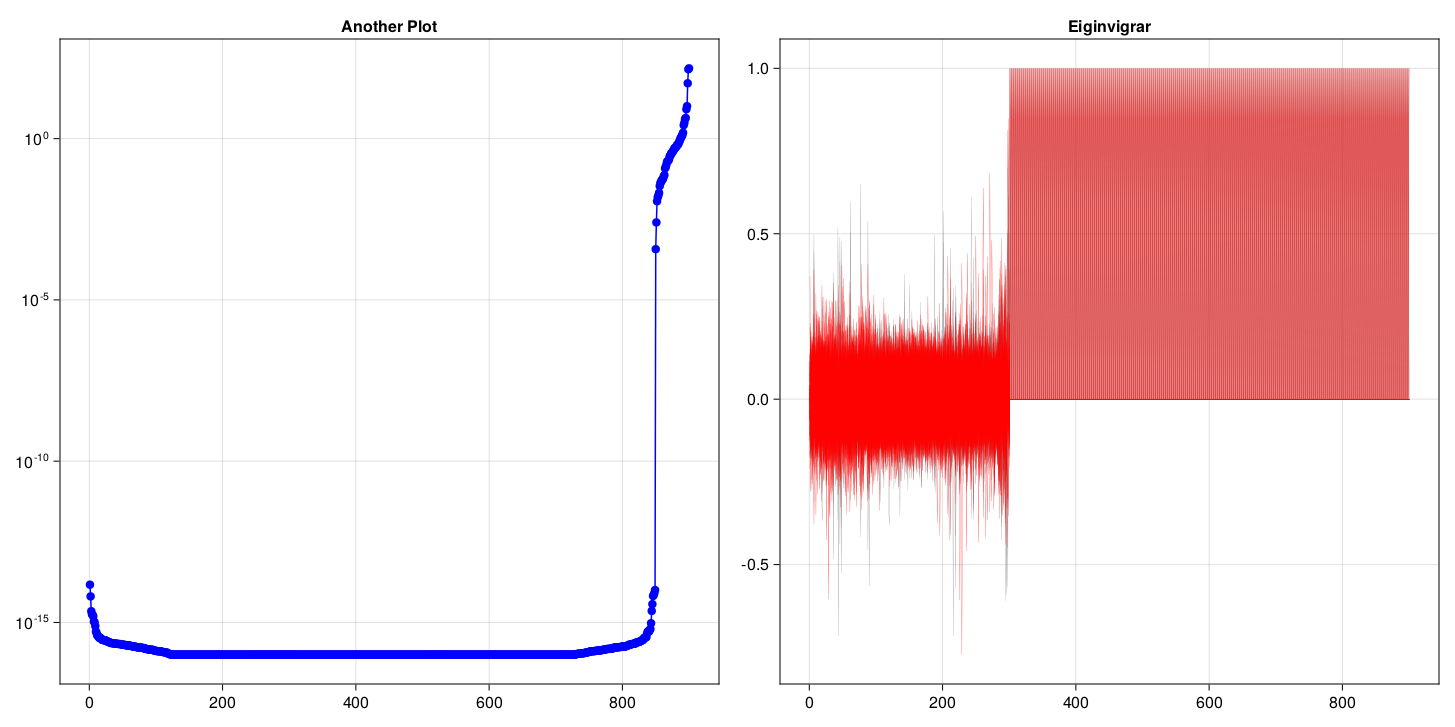

In [111]:
using ColorSchemes

fig = Figure(resolution = (1600/1.1, 800/1.1))

ax1 = Axis(fig[1,2], title="Eiginvigrar")
ax2 = Axis(fig[1,1], yscale=log10, title="Another Plot")

MODEL = 10

for i = eachcol(eigvec1[MODEL])
    CairoMakie.lines!(ax1,i, color=:gray, linewidth=0.2)
end

for i = eachcol(eigvecöll[MODEL])
    CairoMakie.lines!(ax1,i, color=:red, linewidth=0.2)
end



scatter!(ax2,abs.(eigval1[MODEL])+ones(length(eigval1[MODEL]))*10^-16, color=:gray)
lines!(ax2,abs.(eigval1[MODEL])+ones(length(eigval1[MODEL]))*10^-16, color=:gray)

fig

In [51]:
using LinearAlgebra

function eigenNTK(Θ, show_progress)
    
end

eigenNTK (generic function with 1 method)

<h1>Tímaglasið<h1>